# Bayesian Neural Net (Torch)

Libraries import

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display

import torch
import torch.nn as nn
import torch.optim as optim
from blitz.modules import BayesianLinear
from blitz.losses import kl_divergence_from_nn
from blitz.utils import variational_estimator

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)

## Dataset load

In [13]:
# Load Diabetes dataset
diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target

# Convert to pandas DataFrame for easier inspection (optional)
df = pd.DataFrame(X, columns=diabetes.feature_names)
df['TARGET'] = y
print("Dataset Info:")
display(df.head())
display(df.describe())
print(f"\nData shapes: X={X.shape}, y={y.shape}")

Dataset Info:


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,TARGET
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,TARGET
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01,346.000000



Data shapes: X=(442, 10), y=(442,)


In [14]:
# Check for missing values
missing_values = df.isnull().sum()
if missing_values.any():
    print("Missing values found in the dataset.")

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features (X) and target (y)
# Scaling y often helps stabilize training for regression NNs
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten() # Flatten after scaling
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).unsqueeze(1) # Add dimension for loss calc
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).unsqueeze(1)

print(f"\nScaled Tensor shapes: X_train={X_train_tensor.shape}, y_train={y_train_tensor.shape}")

Dataset Info:
        age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  TARGET  
0 -0.002592  0.019907 -0.017646   151.0  
1 -0.039493 -0.068332 -0.092204    75.0  
2 -0.002592  0.002861 -0.025930   141.0  
3  0.034309  0.022688 -0.009362   206.0  
4 -0.002592 -0.031988 -0.046641   135.0  
                age           sex           bmi            bp            s1  \
count  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02   
mean  -2.511817e-19  1.230790e-17 -2.245564e-16 -4.797570e-17 -1.381499e-17   
std    4.761905e-02  4.761905e-02  4.761905e-0

In [2]:
# Define the Bayesian Neural Network using Blitz BayesianLinear layers
@variational_estimator
class BayesianRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        # Define Bayesian Linear layers
        self.blinear1 = BayesianLinear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.blinear2 = BayesianLinear(hidden_dim, hidden_dim // 2)
        self.relu2 = nn.ReLU()
        # Output layer: predicts 2 values (mean and raw std dev for Gaussian)
        self.blinear_out = BayesianLinear(hidden_dim // 2, 2)

    def forward(self, x):
        x = self.relu1(self.blinear1(x))
        x = self.relu2(self.blinear2(x))
        output = self.blinear_out(x)
        # Split output into mean (mu) and raw standard deviation (sigma_raw)
        mu, sigma_raw = output[:, 0], output[:, 1]
        # Ensure sigma is positive using softplus
        sigma = torch.nn.functional.softplus(sigma_raw) + 1e-6 # Add epsilon for numerical stability
        return mu.unsqueeze(1), sigma.unsqueeze(1) # Return mu and sigma with feature dim

# Instantiate the model
input_dim = X_train_tensor.shape[1]
hidden_dim = 64 # Adjust as needed
model = BayesianRegressor(input_dim, hidden_dim)

print("\nModel Architecture:")
print(model)


Model Architecture:
BayesianRegressor(
  (blinear1): BayesianLinear(
    (weight_sampler): TrainableRandomDistribution()
    (bias_sampler): TrainableRandomDistribution()
    (weight_prior_dist): PriorWeightDistribution()
    (bias_prior_dist): PriorWeightDistribution()
  )
  (relu1): ReLU()
  (blinear2): BayesianLinear(
    (weight_sampler): TrainableRandomDistribution()
    (bias_sampler): TrainableRandomDistribution()
    (weight_prior_dist): PriorWeightDistribution()
    (bias_prior_dist): PriorWeightDistribution()
  )
  (relu2): ReLU()
  (blinear_out): BayesianLinear(
    (weight_sampler): TrainableRandomDistribution()
    (bias_sampler): TrainableRandomDistribution()
    (weight_prior_dist): PriorWeightDistribution()
    (bias_prior_dist): PriorWeightDistribution()
  )
)


In [3]:
# Define the loss function (Negative Log Likelihood + KL Divergence)
def criterion(pred_mu, pred_sigma, y_true, kl_loss, kl_weight=1.0):
    """
    Calculates the loss for the Bayesian Regressor.
    Loss = NLL + scaled KL-divergence
    """
    # Create the predicted Gaussian distribution
    pred_dist = torch.distributions.Normal(pred_mu, pred_sigma)

    # Calculate Negative Log-Likelihood (NLL)
    nll = -pred_dist.log_prob(y_true).mean() # Average NLL over the batch/data

    # Combine NLL and KL divergence
    # KL loss is often scaled by the number of batches or dataset size
    # Here kl_weight = 1 / num_batches might be used if using batches,
    # or 1 / dataset_size if calculated once per epoch on full data.
    # Blitz's decorator handles some scaling internally, but explicit scaling is safer.
    loss = nll + kl_weight * kl_loss

    return loss

# Define Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# KL Divergence Weight (common strategy: 1 / number of data points)
# Adjust if using mini-batches (e.g., 1 / num_batches)
kl_weight = 1.0 / len(X_train_tensor)
print(f"Using KL weight: {kl_weight:.6f}")

Using KL weight: 0.002833



Starting training...
Epoch [50/500], Loss: 31.3194, Test RMSE (scaled): 0.7402
Epoch [100/500], Loss: 27.2510, Test RMSE (scaled): 0.7240
Epoch [150/500], Loss: 23.2226, Test RMSE (scaled): 0.7188
Epoch [200/500], Loss: 19.0540, Test RMSE (scaled): 0.7073
Epoch [250/500], Loss: 15.0960, Test RMSE (scaled): 0.6981
Epoch [300/500], Loss: 11.3205, Test RMSE (scaled): 0.7109
Epoch [350/500], Loss: 7.7147, Test RMSE (scaled): 0.7128
Epoch [400/500], Loss: 4.9640, Test RMSE (scaled): 0.7745
Epoch [450/500], Loss: 2.8334, Test RMSE (scaled): 0.7880
Epoch [500/500], Loss: 2.2073, Test RMSE (scaled): 0.7938
Training finished.


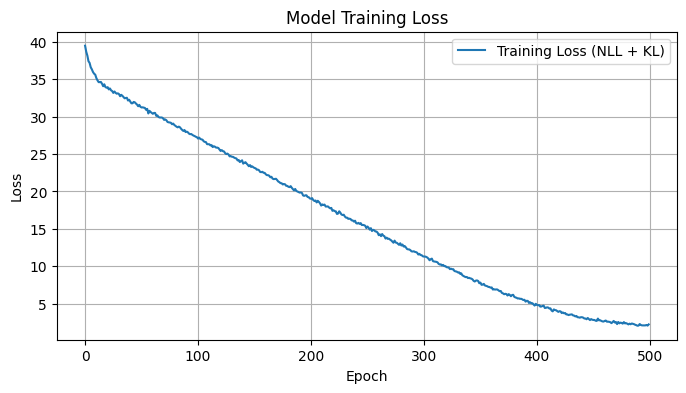

In [4]:
epochs = 500
train_losses = []
test_rmses_scaled = [] # Track RMSE on scaled test data

print("\nStarting training...")
for epoch in range(epochs):
    model.train() # Set model to training mode

    # Forward pass
    pred_mu, pred_sigma = model(X_train_tensor)

    # Calculate KL divergence using the method provided by the decorator
    kl = model.nn_kl_divergence() # Method added by @variational_estimator

    # Calculate loss
    loss = criterion(pred_mu, pred_sigma, y_train_tensor, kl, kl_weight)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # Evaluate on test set periodically (optional, but good practice)
    if (epoch + 1) % 50 == 0:
        model.eval() # Set model to evaluation mode
        with torch.no_grad():
            test_pred_mu, test_pred_sigma = model(X_test_tensor)
            # Calculate RMSE on scaled data for monitoring
            mse = nn.functional.mse_loss(test_pred_mu, y_test_tensor)
            rmse_scaled = torch.sqrt(mse).item()
            test_rmses_scaled.append(rmse_scaled)
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Test RMSE (scaled): {rmse_scaled:.4f}")

print("Training finished.")

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Training Loss (NLL + KL)')
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# Prediction with uncertainty quantification
N_MC_SAMPLES = 100
print(f"\nPerforming {N_MC_SAMPLES} Monte Carlo forward passes for prediction on test set...")

model.eval() # Ensure model is in evaluation mode

test_pred_mus_mc = []
test_pred_sigmas_mc = []

with torch.no_grad():
    for _ in range(N_MC_SAMPLES):
        pred_mu_mc, pred_sigma_mc = model(X_test_tensor)
        test_pred_mus_mc.append(pred_mu_mc.numpy())
        test_pred_sigmas_mc.append(pred_sigma_mc.numpy())

# Stack predictions from all MC samples
test_pred_mus_mc = np.array(test_pred_mus_mc)     # Shape: (N_MC_SAMPLES, N_TEST_SAMPLES, 1)
test_pred_sigmas_mc = np.array(test_pred_sigmas_mc) # Shape: (N_MC_SAMPLES, N_TEST_SAMPLES, 1)

# Calculate predictive mean (average over MC samples)
predictive_mean_scaled = np.mean(test_pred_mus_mc, axis=0) # Shape: (N_TEST_SAMPLES, 1)

# Calculate aleatoric uncertainty (average predicted std dev)
aleatoric_std_scaled = np.mean(test_pred_sigmas_mc, axis=0) # Shape: (N_TEST_SAMPLES, 1)

# Calculate epistemic uncertainty (std dev of predicted means)
epistemic_std_scaled = np.std(test_pred_mus_mc, axis=0) # Shape: (N_TEST_SAMPLES, 1)

# Calculate total uncertainty (using law of total variance approximation)
# Total Variance approx= E[Var(Y|W)] + Var(E[Y|W]) = mean(sigma^2) + var(mu)
total_variance_scaled = np.mean(test_pred_sigmas_mc**2, axis=0) + np.var(test_pred_mus_mc, axis=0)
total_std_scaled = np.sqrt(total_variance_scaled) # Shape: (N_TEST_SAMPLES, 1)


# --- Inverse transform predictions back to original scale ---
predictive_mean = y_scaler.inverse_transform(predictive_mean_scaled)

# Standard deviation needs careful handling during inverse transform.
# Since StandardScaler is y_scaled = (y - mean) / scale, then y = y_scaled * scale + mean.
# The standard deviation transforms by scaling: std_dev_orig = std_dev_scaled * scale
y_scale = y_scaler.scale_[0] # Get the scaling factor from the scaler
aleatoric_std = aleatoric_std_scaled * y_scale
epistemic_std = epistemic_std_scaled * y_scale
total_std = total_std_scaled * y_scale

print("Prediction finished.")


Performing 100 Monte Carlo forward passes for prediction on test set...
Prediction finished.


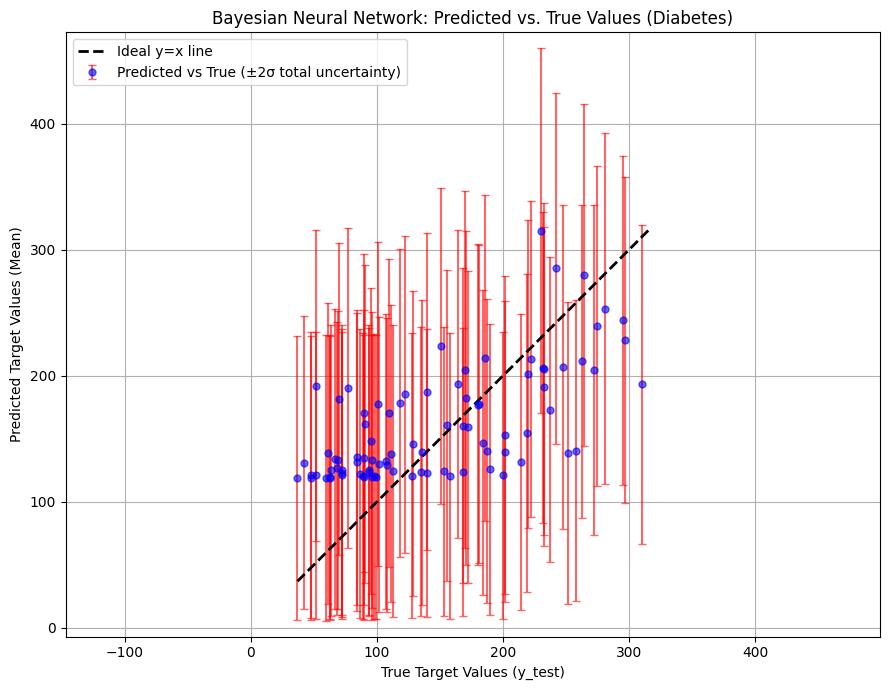

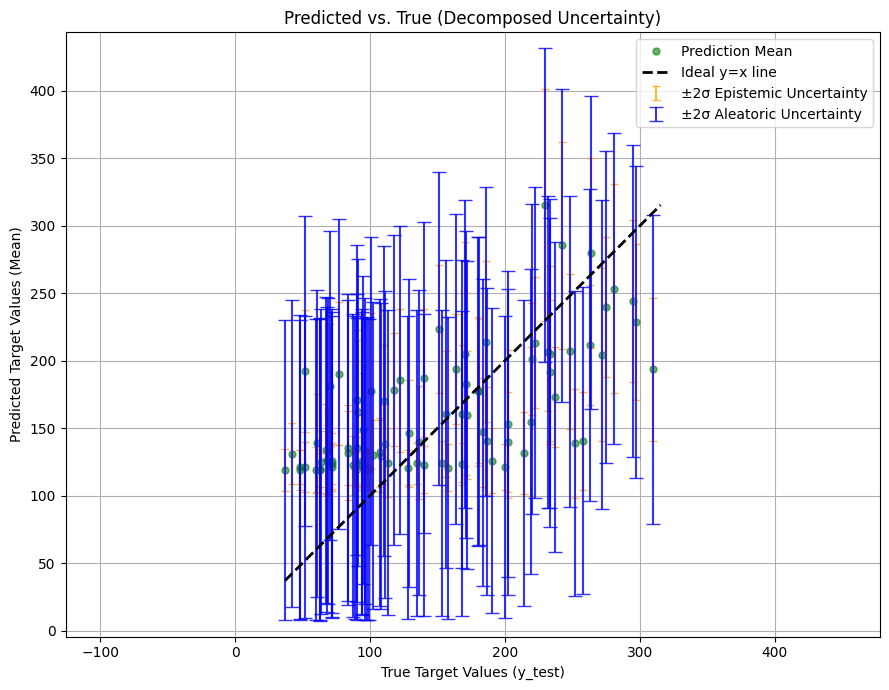


Final Test RMSE (original scale): 56.6531


In [7]:
# 7. Plotting the Results

# --- Convert RGBA strings to Matplotlib tuples (0-1 range) ---
# Original: 'rgba(255, 0, 0, 0.3)' -> Red, 0.3 Alpha
total_unc_color = (1.0, 0.0, 0.0, 0.3)
# Original: 'rgba(255, 165, 0, 0.4)' -> Orange, 0.4 Alpha
epistemic_unc_color = (1.0, 165/255, 0.0, 0.4)
# Original: 'rgba(0, 0, 255, 0.2)' -> Blue, 0.2 Alpha
aleatoric_unc_color = (0.0, 0.0, 1.0, 0.2)


plt.figure(figsize=(9, 7))

# Plot predicted vs true values with TOTAL uncertainty
plt.errorbar(y_test, predictive_mean.flatten(), yerr=total_std.flatten() * 2, # Use 2*std dev for ~95% interval
             fmt='o', # 'o' for points, no line connecting them
             ecolor=total_unc_color,      # Use the corrected tuple
             color='blue',                # Point color
             markersize=5, alpha=0.6, capsize=3, # Point size, transparency, error bar cap size
             label='Predicted vs True (±2σ total uncertainty)')


# Plot the ideal y=x line
min_val = min(y_test.min(), predictive_mean.min())
max_val = max(y_test.max(), predictive_mean.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Ideal y=x line')

plt.title('Bayesian Neural Network: Predicted vs. True Values (Diabetes)')
plt.xlabel('True Target Values (y_test)')
plt.ylabel('Predicted Target Values (Mean)')
plt.legend()
plt.grid(True)
plt.axis('equal') # Ensure x and y axes have the same scale for the y=x line
plt.tight_layout()
plt.show()

# Optional: Plot decomposed uncertainties (similar plot, different error bars)
plt.figure(figsize=(9, 7))
# Plot points first (green in this case)
plt.plot(y_test, predictive_mean.flatten(), 'o', color='green', markersize=5, alpha=0.6, label='Prediction Mean')

# Plot Epistemic Uncertainty error bars
plt.errorbar(y_test, predictive_mean.flatten(), yerr=epistemic_std.flatten() * 2, fmt='none', # 'none' means no marker/line for the data itself
             ecolor=epistemic_unc_color, # Corrected tuple
             alpha=0.8, # Make error bars slightly less transparent than points
             capsize=3,
             label='±2σ Epistemic Uncertainty')

# Plot Aleatoric Uncertainty error bars (overlayed)
plt.errorbar(y_test, predictive_mean.flatten(), yerr=aleatoric_std.flatten() * 2, fmt='none',
             ecolor=aleatoric_unc_color, # Corrected tuple
             alpha=0.8,
             capsize=5, # Slightly different capsize to distinguish if needed
             label='±2σ Aleatoric Uncertainty')

# Plot the ideal y=x line
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Ideal y=x line')
plt.title('Predicted vs. True (Decomposed Uncertainty)')
plt.xlabel('True Target Values (y_test)')
plt.ylabel('Predicted Target Values (Mean)')
# Adjust legend order potentially
handles, labels = plt.gca().get_legend_handles_labels()
# Example: order = [3, 0, 1, 2] # Order: Ideal, Prediction, Epistemic, Aleatoric
# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.legend() # Default order is usually fine
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()

# Calculate final Test RMSE on original scale
test_rmse = np.sqrt(np.mean((predictive_mean.flatten() - y_test)**2))
print(f"\nFinal Test RMSE (original scale): {test_rmse:.4f}")

ValueError: 'rgba(255, 0, 0, 0.3)' is not a valid color value.

Error in callback <function _draw_all_if_interactive at 0x0000021FAEE2E280> (for post_execute):


ValueError: 'rgba(255, 0, 0, 0.3)' is not a valid color value.

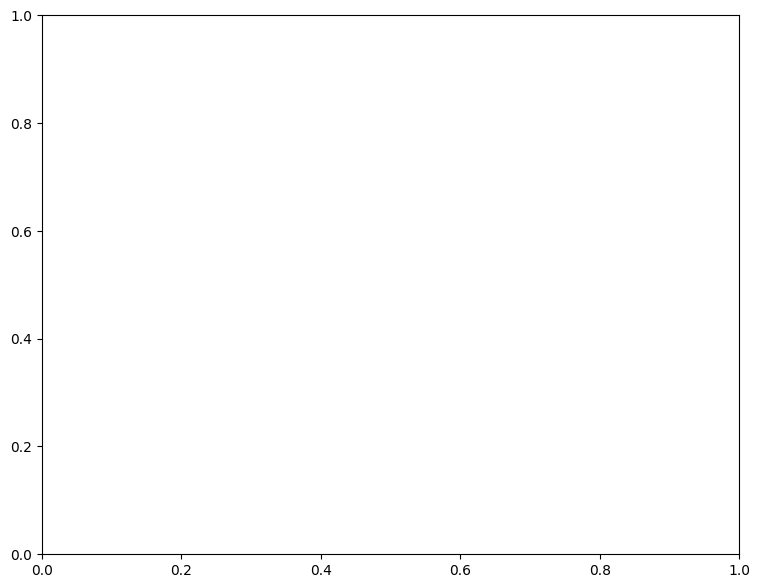

In [6]:
plt.figure(figsize=(9, 7))

# Plot predicted vs true values
plt.errorbar(y_test, predictive_mean.flatten(), yerr=total_std.flatten() * 2, # Use 2*std dev for ~95% interval
             fmt='o', # 'o' for points, no line connecting them
             ecolor='rgba(255, 0, 0, 0.3)', # Error bar color and transparency
             color='blue', # Point color
             markersize=5, alpha=0.6, capsize=3, # Point size, transparency, error bar cap size
             label='Predicted vs True (±2σ total uncertainty)')


# Plot the ideal y=x line
min_val = min(y_test.min(), predictive_mean.min())
max_val = max(y_test.max(), predictive_mean.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Ideal y=x line')

plt.title('Bayesian Neural Network: Predicted vs. True Values (Diabetes)')
plt.xlabel('True Target Values (y_test)')
plt.ylabel('Predicted Target Values (Mean)')
plt.legend()
plt.grid(True)
plt.axis('equal') # Ensure x and y axes have the same scale for the y=x line
plt.tight_layout()
plt.show()

# Optional: Plot decomposed uncertainties (similar plot, different error bars)
plt.figure(figsize=(9, 7))
plt.errorbar(y_test, predictive_mean.flatten(), yerr=epistemic_std.flatten() * 2, fmt='o',
             ecolor='rgba(255, 165, 0, 0.4)', color='green', markersize=5, alpha=0.6, capsize=3,
             label='Predicted vs True (±2σ epistemic uncertainty)')
plt.errorbar(y_test, predictive_mean.flatten(), yerr=aleatoric_std.flatten() * 2, fmt='o',
             ecolor='rgba(0, 0, 255, 0.2)', color='green', markersize=5, alpha=0.6, capsize=0, # No capsize if overlapping
             label='Predicted vs True (±2σ aleatoric uncertainty)')
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Ideal y=x line')
plt.title('Predicted vs. True (Decomposed Uncertainty)')
plt.xlabel('True Target Values (y_test)')
plt.ylabel('Predicted Target Values (Mean)')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()

# Calculate final Test RMSE on original scale
test_rmse = np.sqrt(np.mean((predictive_mean.flatten() - y_test)**2))
print(f"\nFinal Test RMSE (original scale): {test_rmse:.4f}")